In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
class Architecture:
    def __init__(self):
        self.space_flag = 0
        self.c_capacity, self.s_capacity = 1000, 100                                         # Capacity of the devices
        # self.a1, self.a2, self.a3, self.mc = 0.000125, 0.000010, 0.000200, 0.001             # Weight of every type of data
        self.weights = [0.0125, 0.0010, 0.0200, 0.1000]                                      # a1, a2, a3, mc
        self.lifetime = {'a1': 10000, 'a2': 20000, 'a3': 10000, 'mc': 1000}                             # Max lifetime of the different data types
        self.total_c = 2
        self.total_s = 6
        self.max_actions = 20

        self.devices = {}
        self.data = {
            'a1': {},
            'a2': {},
            'a3': {},
            'mc': {},
        }
        self.latencies = {}

        for i in range(self.total_c):
            for j in (self.data.keys()):
                self.data[j]['c'+str(i)] = 0
            self.devices['c'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['c'+str(i)] = {}
        for i in range(self.total_s):
            for j in (self.data.keys()):
                self.data[j]['s'+str(i)] = 0
            self.devices['s'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['s'+str(i)] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.action_type = []
        self.action_device = []

        randomized = list(self.devices.keys())
        random.shuffle(randomized)

        bound = round(len(self.devices)/4)

        self.clusters = {
            'a1': randomized[:bound],
            'a2': randomized[bound:bound*2],
            'a3': randomized[bound*2:bound*3],
            'mc': randomized[bound*3:]
        }

        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation,self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def update(self,data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in self.devices.keys():
            if list(i)[0] == 'c':
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= 0.2:
                self.space_flag = i
        return load

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.total_c]
        ss = keys[self.total_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.total_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.total_c)+len(ss)%self.total_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        plt.title("Architecture:")
        plt.axis('off')
        plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def generate(self, operation):
        if operation == 'a1' or operation == 'a2' or operation == 'a3':
            for i in self.devices.keys():
                self.update(operation,i)
        elif operation == 'mc':
            for i in self.devices.keys():
                if list(i)[0] == 's':
                    self.update('mc',i)
        elif operation.split('_')[0] == 'ai':
            device=random.sample(list(self.clusters[operation.split('_')[1]]),1)
            self.action_device.append(device[0])
            self.action_type.append(operation.split('_')[1])
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def greedy_algorithm(self): # baseline?
        if self.space_flag == 0:
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation
            self.construct_dictionaries()
            result = self.free_space()
        else:
            print('enter')
            problematic_key = None
            for key, value in arch.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            arch.clusters[problematic_key].extend(element for element in arch.devices if element[0]==('c'))
            self.space_flag = 0
            result = self.greedy_algorithm()

        return result

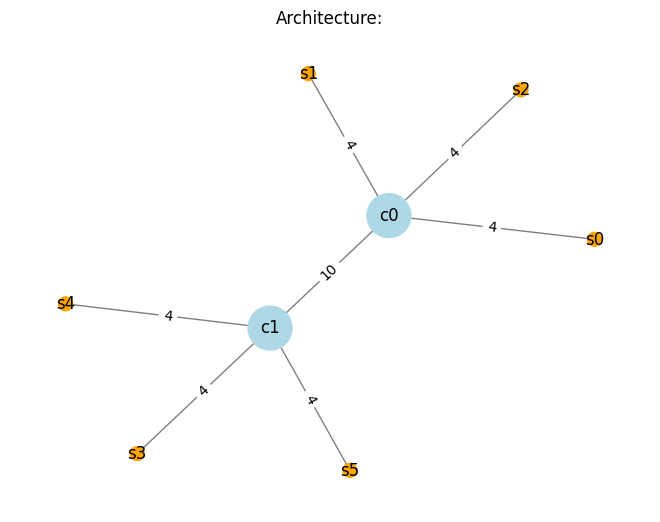

In [3]:
arch = Architecture()

In [4]:
executions = ['a1','a2','mc','a1','ai_a2','mc','a3','ai_a1','mc','a1','ai_a3','mc','a2','a3','ai_a2','mc','ai_a1','a1','mc','ai_a3','ai_mc']

df = pd.DataFrame(columns=['c0','c1','s0','s1','s2','s3','s4','s5'])

for j in tqdm(range(2000)):
    for i in executions:
        arch.generate(i)
        arch.heart_beat()
        df.loc[len(df)] = list(arch.greedy_algorithm().values())
        # print(list(arch.free_space().values()))
# arch.generate('a1')
# arch.heart_beat()
# arch.generate('ai_a1')
# arch.heart_beat()
# print(arch.data_types, arch.data_allocation, arch.data_times)
# arch.free_space()
print(arch.compute_total_latency())

  2%|██▍                                                                                                            | 44/2000 [00:03<04:47,  6.81it/s]

enter


 20%|█████████████████████▌                                                                                        | 391/2000 [02:58<22:37,  1.19it/s]

enter


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [36:05<00:00,  1.08s/it]

1319564


            c0      c1       s0       s1      s2     s3     s4       s5
896   0.999678  0.9274  0.91450  0.99634  0.9344  0.928  0.190  0.91450
8225  0.955843  0.9115  0.19975  0.96885  0.3696  0.376  0.585  0.23325


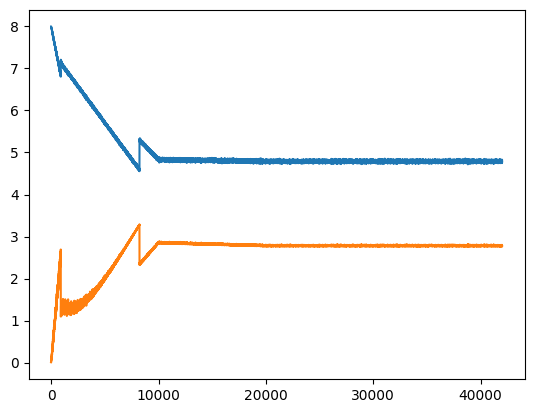

In [28]:
print(df[(df<=0.2).any(axis=1)])
# df_test = df.loc[1:2]
df_test = df.sum(axis=1)
df_test2 = df.std(axis=1)*10
plt.plot(df_test)
plt.plot(df_test2)
plt.show()

In [29]:
np.std(df.loc[8225])

0.3067750076996322